# Do you Even Lift: Using Stochastic Gradient Descent to Determine the Best Times to Go to the Gym

## Table of Contents

* [Introduction](#introduction)
* [Goal](#goal)
* [Summary](#summary)
* [The Data](#the_data)
  * [EDA and Data Cleaning](#eda_and_data_cleaning)
  * [Plots](#plots)
* [Building the Model](#building_the_model)
  * [Scaling the Data](#scaling_the_data)
  * [Measuring the Model's Performance](#measuring_the_models_performance)
  * [Hyperparameter Optimisation](#hyperparameter_optimisation)
* [Visualizing the Results](#visualizing_the_results)
* [Conclusion](#conclusion)
* [Next steps](#next_steps)

## Introduction  <a name="introduction"></a>

I like going to the gym, but I really dislike getting to the gym and finding that it is so crowded that I must wait to use the machines I want. As a data scientist in a major insurance provider, I don't have much time to spend at the gym, but I have a very particular set of skills. Skills I have acquired over a very long career. Skills that make me perfect to tackle this issue.
Using these skills I'm planning to build a model that will help me predict the best time to go to the gym and avoid crowds, so I can enjoy a great workout with minimal wait times and no crowds.

## Goal  <a name="goal"></a>

The goal is to develop a predictive model that can accurately forecast the number of visitors at the gym. The model should perform well across a variety of metrics, including R-squared, MSE, and MAE.

## Summary  <a name="summary"></a>
The initial SGDRegressor model performed poorly, achieving an R-squared below 50% even after hyperparameter tuning. To address these limitations, the recommendation is to explore more advanced regression models like Random Forest, XGBoost, or LightGBM. These alternatives should better handle the non-linear relationships and extreme values present in the gym attendance data.

## The Data <a name="the_data"></a>

The “Crowdedness at the Campus Gym” dataset contains historical information about how crowded the campus gym is on a given day and hour, as well as other specific information about the specific days.

The [dataset](https://www.kaggle.com/datasets/nsrose7224/crowdedness-at-the-campus-gym) has been uploaded to Kaggle by [Nick Rose](https://www.kaggle.com/nsrose7224) under the [Database Contents License (DbCL) v1.0](https://opendatacommons.org/licenses/dbcl/1-0/).

### EDA and Data Cleaning <a name="eda_and_data_cleaning"></a>

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [1]:
# Data analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Leaning imports
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading the file
data = pd.read_csv("crowdness_gym_data.csv")

In [3]:
data.shape

(62184, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [5]:
data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


The dataset has `62,184` observations, each with `11` features.
There are no missing values in the dataset.

The features are as follows:

1. `number_people`: this is the number of people at the gym at each observation. This will be my target variable or label
2. `date`: a string value with the specific date and time information
3. `timestamp`: an integer (int), with the number of seconds since the start of the day (00:00)
4. `dayofweek`: an integer (int) representing the day of week [`0`:Monday, `1`:Tuesday, `2`:Wednesday, `3`:Thursday, `4`:Friday, `5`:Saturday, `6`:Sunday]
5. `is_weekend`: a Boolean value defining if this observation happened during a weekend [`1`: Yes, `0`: No]
6. `is_holiday`: a Boolean value defining if the observation happened during a holiday [`1`: Yes, `0`: No]
7. `temperature`: a float, defining the temperature during the day of the observation [`°F`]
8. `isstartof_semester`: a Boolean defining if the observation happened in the first 2 weeks of a semester [`1`: Yes, `0`: No]
9. `is_during_semester`: a Boolean defining if the observation happened during the active semester [`1`: Yes, `0`: No]
10. `month`: an integer (int) defining the month of the year [`1`: January, `2`: February,..., `12`: December]
11. `hour`: an integer (int) for the hour of the day from [`0`-`23`]

Of the features, `date` is a string, 6 are numeric (`number_people`, `timestamp`, `temperature`, `day_of_week`, `month` and `hour`) and the other 4 are categorical.

Since `date` is a string (and not a `datetime` object) and since it doesn't provide any information I can't get from other columns, I can safely remove it from the dataset.
I can also remove `timestamp`, since it has the same information as `hour`, only in resolution that's much higher than my needs for the purposes of this project.

In [6]:
data = data.drop(['date', 'timestamp'], axis=1)

Let's get some statistics about the data:

In [7]:
data.describe()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


The numerical features seem to behave nicely, with the mean around the mode (i.e., symmetrically distributed) and no glaring outliers.

Next, let's generate plots of the data:

### Plots <a name="plots"></a>

First, let's look at relations between the number of people at the gym and the time units in the dataset:

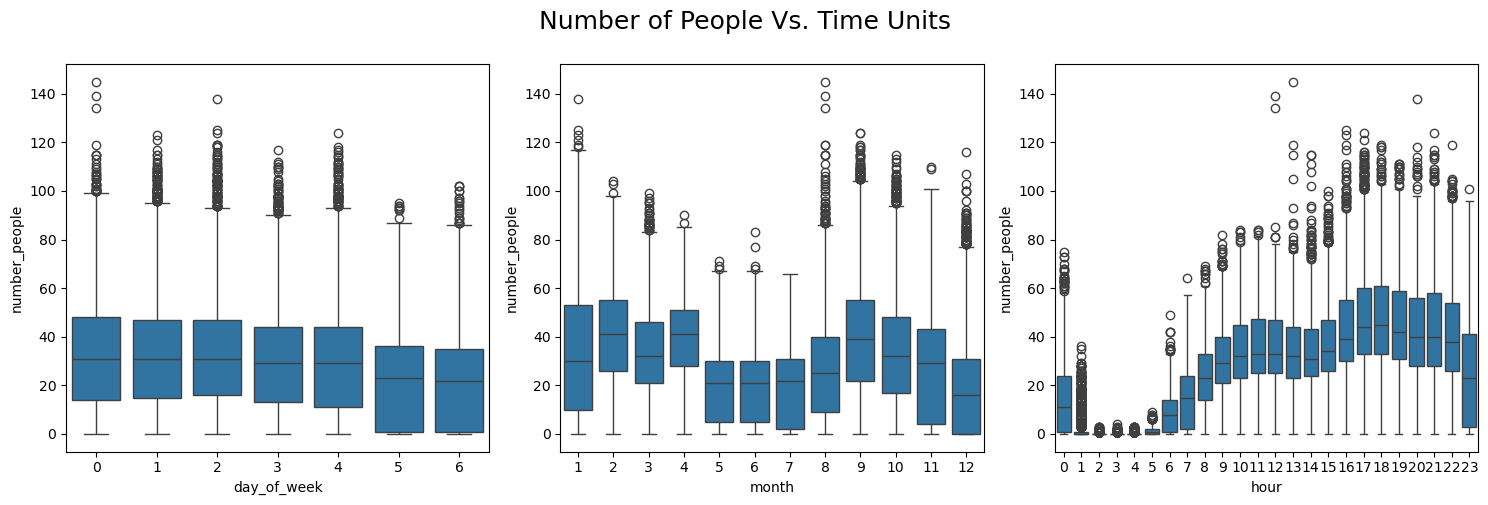

In [8]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(hspace=0.2)

cols = ['day_of_week', 'month', 'hour'] 
# set number of columns
ncols = 3
# calculate number of rows
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

# loop through the length of cols and keep track of index
for i, col in enumerate(cols):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, i + 1)

    # plot the feature on the new subplot axis
    sns.boxplot(x=data[col], y=data['number_people'])
    #plt.scatter(data[col], data['number_people'])

    # chart formatting
    ax.set_xlabel(col)
plt.suptitle("Number of People Vs. Time Units", fontsize=18, y=1.0)
plt.tight_layout()
plt.show()

From the above box plots, I can learn that:
* The most popular `day` is Monday, followed by Wednesday, then Friday, with Saturday being the least popular day to go the the gym
* The busiest `month` in the year is August, followed by January. May-July are the least busy months.
* Interestingly, December has the lowest median and one of the lowest upper quartiles (75th percentile), but there are several outlier data points that extend significantly above the box. This suggests that even though December is typically the slowest month, there are still some unusually busy days or periods within that month. These outliers stand out in contrast to the generally low median and tight range of the rest of the December data. It implies there is still significant variability and potential for high traffic at the gym, even during what is otherwise the least busy time of year.
* The `hour` boxplot shows an expected increase in gym attendance as the day progresses. the AM hours are significantly less busy than the PM ones, with 2am-5am being the slowest times, and may be the best times to visit the gym; if I'm awake, that is.

Next, let's look at the correlations between the various columns to try and find interesting relationships:

In [9]:
data.corr()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
number_people,1.000000,-0.162062,-0.173958,-0.048249,0.373327,0.182683,0.335350,-0.097854,0.552049
day_of_week,-0.162062,1.000000,0.791338,-0.075862,0.011169,-0.011782,-0.004824,0.015559,-0.001914
is_weekend,-0.173958,0.791338,1.000000,-0.031899,0.020673,-0.016646,-0.036127,0.008462,-0.000517
is_holiday,-0.048249,-0.075862,-0.031899,1.000000,-0.088527,-0.014858,-0.070798,-0.094942,0.002843
temperature,0.373327,0.011169,0.020673,-0.088527,1.000000,0.093242,0.152476,0.063125,0.185121
is_start_of_semester,0.182683,-0.011782,-0.016646,-0.014858,0.093242,1.000000,0.209862,-0.137160,0.010091
is_during_semester,0.335350,-0.004824,-0.036127,-0.070798,0.152476,0.209862,1.000000,0.096556,0.045581
month,-0.097854,0.015559,0.008462,-0.094942,0.063125,-0.137160,0.096556,1.000000,-0.023624
hour,0.552049,-0.001914,-0.000517,0.002843,0.185121,0.010091,0.045581,-0.023624,1.000000


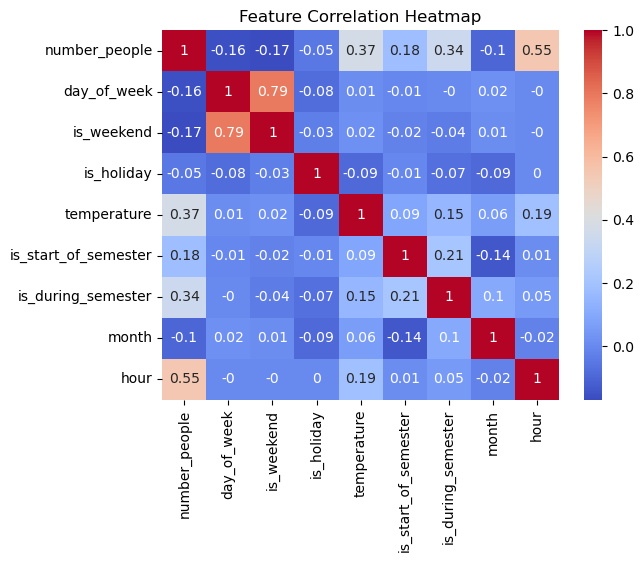

In [10]:
sns.heatmap(round(data.corr(), 2), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

The target column is `number_people`, and while it doesn't correlate highly with any particular column, it does have medium correlations with `hour` (`55%`), `temperature` (`37%`), and `is_during_semester` (`34%`).

## Building the Model <a name="building_the_model"></a>

I'll be using `SGDRegressor` as the ML model for this project. Before building the model I need to split the data into train and test sets. 

I'm saving 20% of the data as a test set (test size of `20%`, or `0.2`). Keeping the random state constant for reproducibility.

In [11]:
relevant_columns = ['hour', 'temperature', 'is_during_semester']
X = data[relevant_columns]
y = data['number_people']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Scaling the Data <a name="scaling_the_data"></a>
Next, let's scale the data to normalise the features:

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now I can build and fit the model. Using low tolerance and initial learning rate of `0.0001` and `10,000` iterations. The learning rate is `adaptive`, meaning it's divided by 5 when there's no change in the training loss validation score 5 consecutive times.

In [13]:
tolerance = 0.0001
initial_learning_rate = 0.0001
iterations = 10_000
sgdr = SGDRegressor(tol=tolerance, max_iter=iterations, eta0=initial_learning_rate, learning_rate='adaptive', random_state=1)
sgdr.fit(X_train_scaled, y_train)

SGDRegressor(eta0=0.0001, learning_rate='adaptive', max_iter=10000,
             random_state=1, tol=0.0001)

### Measuring the Model's Performance <a name="measuring_the_models_performance"></a>

I'll use the Mean Square Error (`MSE`), Mean Absolute Error (`MAE`) and $R^2$ Score (`R2`) to measure the model's performance.

In [14]:
y_pred = sgdr.predict(X_test_scaled)

sgdr_mse = mean_squared_error(y_test, y_pred)
print(f"The MSE is: {sgdr_mse}")
sgdr_mae = mean_absolute_error(y_test, y_pred)
print(f"The MAE is: {sgdr_mae}")
sgdr_r2 = r2_score(y_test, y_pred)
print(f"The R2 score is: {sgdr_r2}")

The MSE is: 286.2303778606504
The MAE is: 12.973919757451469
The R2 score is: 0.44988058479794546


The MSE and MAE are higher than I'd like, and the $R^2$ score is too low. All that points to a model that's not good enough at predicting data.
Perhaps the parameters aren't quite right. Let's use hyperparameter optimisation to try and find parameters that will allow the model to make better predictions:

### Hyperparameter Optimisation <a name="hyperparameter_optimisation"></a>

In [15]:
# Creating a parameter grid for our model, with some typical ranges on top of the ones used when building the previous model
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.0001, 0.01, 0.1, 1.0],
    'max_iter': [1000, 2000, 5000, 10000],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'tol':[0.0001, 0.001]
}

grid_search = GridSearchCV(SGDRegressor(random_state=1), param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=1),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.0001, 0.01, 0.1, 1.0],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'max_iter': [1000, 2000, 5000, 10000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.0001, 0.001]})

What are the parameters that provided the best result?

In [16]:
grid_search.best_params_

{'alpha': 0.0001,
 'eta0': 0.0001,
 'learning_rate': 'adaptive',
 'max_iter': 1000,
 'penalty': 'l1',
 'tol': 0.001}

And how much did the metrics improve relative to the previous model?

In [17]:
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

sgdr_mse = mean_squared_error(y_test, y_pred)
print(f"The MSE is: {sgdr_mse}")
sgdr_mae = mean_absolute_error(y_test, y_pred)
print(f"The MAE is: {sgdr_mae}")
sgdr_r2 = r2_score(y_test, y_pred)
print(f"The R2 score is: {sgdr_r2}")

The MSE is: 286.23002419959346
The MAE is: 12.973821532818976
The R2 score is: 0.4498812645155047


Well, that's disappointing. I ran about 1,500 different parameter configurations, and couldn't find a single one that was better than the ones I initially used. Let's see how well the model behaves, in graph form:

## Visualizing the Results <a name="visualizing_the_results"></a>

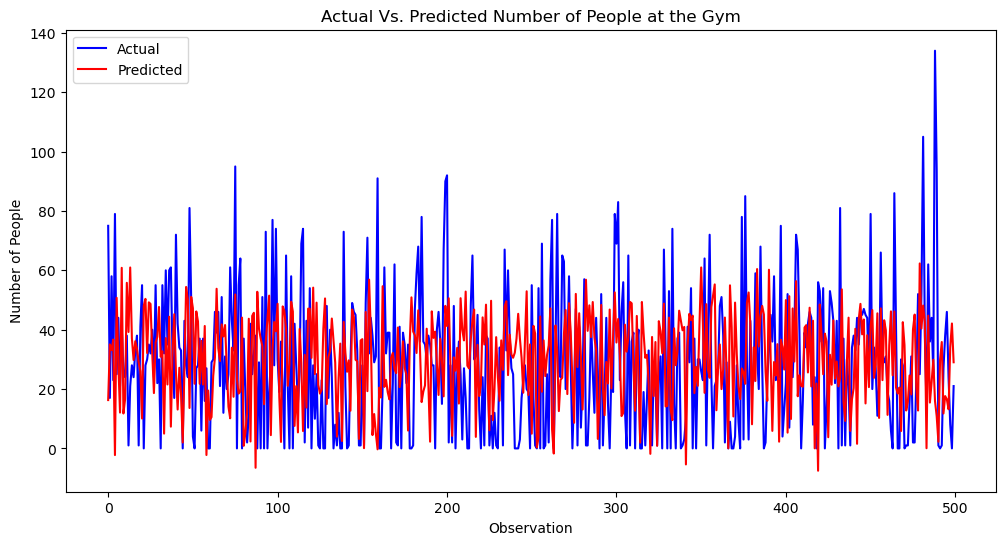

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(np.random.choice(y_test, 500), c = 'blue', label = 'Actual', ax=ax)
sns.lineplot(np.random.choice(y_pred, 500), c = 'red', label = 'Predicted', ax=ax)
ax.legend()
plt.ylabel("Number of People")
plt.xlabel("Observation")
plt.title('Actual Vs. Predicted Number of People at the Gym');
plt.show()

Let's now look at a Kernel Density Estimation plot, to get an understanding of the distributions of the actual and the predicted number of people at the gym:

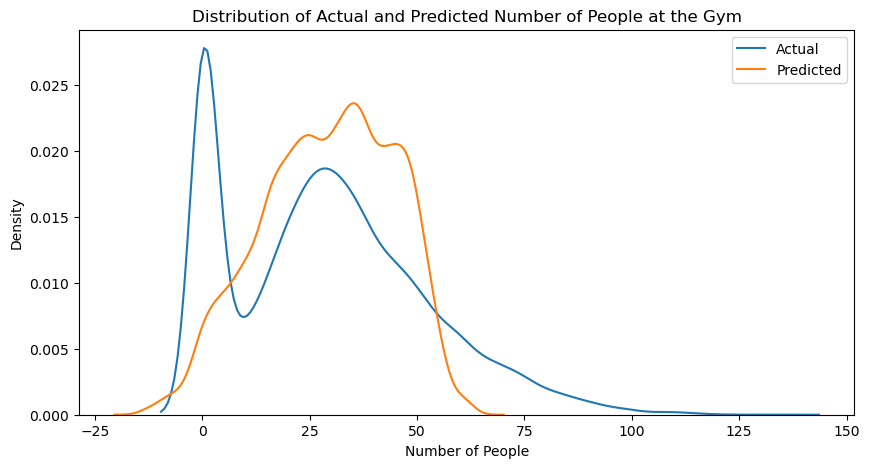

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.kdeplot(y_test, ax = ax, label = 'Actual')
sns.kdeplot(y_pred, ax = ax, label = 'Predicted')
ax.legend()
plt.xlabel("Number of People")
plt.title('Distribution of Actual and Predicted Number of People at the Gym');#
plt.show()

The plots reinforce the conclusion that the model doesn't perform well at predicting the data, and let us make some observations:
- The model lack the variability of the actual data
- The model's predictions cluster around 20-40 people, underpredicting high values and overpredicting low ones
- The actual data displays a bi-modal, right-skewed distribution with a long tail
- The predicted distribution is more concentrated and symmetric than the actual
- The model fails to capture the full range of the actual data, particularly higher values

Main problems with the model:

- It's too conservative in its predictions, staying too close to the mean
- It's not capturing the extremes well, especially high attendance periods
- It's missing the bimodal nature of the actual gym attendance
- The model seems to be oversimplifying the complex patterns in the data

## Conclusion <a name="conclusion"></a>

Based on my analysis, the SGDRegressor model did not perform well, with an $R^2$ value below 50% even after hyperparameter tuning. The key issues were:

* The model lacked the variability to capture the nature of the distribution of the actual gym attendance data
* It tended to underpredict high attendance periods and overpredict low attendance
* It oversimplified the complex patterns in the data

Given these limitations, the SGDRegressor is not the right model for this prediction task.

## Next steps <a name="next_steps"></a>

* Explore more sophisticated models like Random Forest, XGBoost, or LightGBM that can better handle non-linear relationships and extreme values
* Engineer additional features that may capture seasonal, day-of-week, or other patterns in gym attendance
* Perform thorough cross-validation to ensure robust model evaluation

The goal should be finding a model that can accurately predict the full distribution of gym attendance, including typical and peak periods. With the right approach, the data can potentially provide valuable insights for finding peak and trough gym attendance.